# Mood Prediction
In this notebook, two experiments are performed, a regression and classification task.

Feature selection is performed by first engineering additional variables and calculating correlation, filtering out redundant variables that lack predictive power and then running the regression task of predicting my mood on a 5 point scale and then a classification task of a good or bad day.

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime as dt
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret.classification as c
import pycaret.regression as r
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_pickle('../data/all.csv')

## Feature Selection
For feature selection I will be calculating the correlation of all variables to Mood. I will set the threshold of 0.5 for what is acceptable as a feature for the ml algorithm

I will perform feature engineering by creating the square of features and their rolling 7 day average.

In [3]:
features = ['Stress', 'Sleepiness', 'CaloriesBurned', 'Steps', 'Distance',
       'Floors', 'SedentaryMinutes', 'LightlyActiveMinutes',
       'FairlyActiveMinutes', 'VeryActiveMinutes', 'ActivityCalories', 'FB_Onset', 'FB_Offset', 'FB_TST', 'FB_WASO',
       'FB_NOA', 'FB_TIB', 'FB_REMSD', 'FB_LSD', 'FB_DSD', 'FB_TSDP', 'FB_AI',
       'FB_SWSP', 'FB_REMP', 'FB_SMI', 'FB_Midpoint', 'FB_MWD', 'FB_SR', 'SS_Bedtime', 'SS_SOL', 'SS_TST', 'SS_WASO',
       'SS_Waketime', 'SS_TIB', 'SS_NOA', 'SS_LSD', 'SS_DSD', 'SS_REMSD',
       'SS_ARR', 'SS_SS', 'SS_MS', 'SS_BS', 'SS_SE', 'SS_SMI', 'SS_AI',
       'SS_REMP', 'SS_SWSP', 'SS_Onset', 'SS_Offset', 'SS_TSDP', 'SS_Midpoint', 'SS_MWD',
       'SS_SR']

for col in features: 
    df[col + '_sq'] = df[col] ** 2
    df[col + '_R7DM'] = df[col].rolling(7, 1).mean()

In [4]:
df.columns[-50:]

Index(['SS_Bedtime_sq', 'SS_Bedtime_R7DM', 'SS_SOL_sq', 'SS_SOL_R7DM',
       'SS_TST_sq', 'SS_TST_R7DM', 'SS_WASO_sq', 'SS_WASO_R7DM',
       'SS_Waketime_sq', 'SS_Waketime_R7DM', 'SS_TIB_sq', 'SS_TIB_R7DM',
       'SS_NOA_sq', 'SS_NOA_R7DM', 'SS_LSD_sq', 'SS_LSD_R7DM', 'SS_DSD_sq',
       'SS_DSD_R7DM', 'SS_REMSD_sq', 'SS_REMSD_R7DM', 'SS_ARR_sq',
       'SS_ARR_R7DM', 'SS_SS_sq', 'SS_SS_R7DM', 'SS_MS_sq', 'SS_MS_R7DM',
       'SS_BS_sq', 'SS_BS_R7DM', 'SS_SE_sq', 'SS_SE_R7DM', 'SS_SMI_sq',
       'SS_SMI_R7DM', 'SS_AI_sq', 'SS_AI_R7DM', 'SS_REMP_sq', 'SS_REMP_R7DM',
       'SS_SWSP_sq', 'SS_SWSP_R7DM', 'SS_Onset_sq', 'SS_Onset_R7DM',
       'SS_Offset_sq', 'SS_Offset_R7DM', 'SS_TSDP_sq', 'SS_TSDP_R7DM',
       'SS_Midpoint_sq', 'SS_Midpoint_R7DM', 'SS_MWD_sq', 'SS_MWD_R7DM',
       'SS_SR_sq', 'SS_SR_R7DM'],
      dtype='object')

In [5]:
threshold = .25
corr = abs(df.corr()[['Mood_num', 'Mood_bin_num']])
corr = corr[corr > threshold].dropna(how='any')

In [6]:
features = list(corr.index) # removing target, square and cube features as they do not add much value

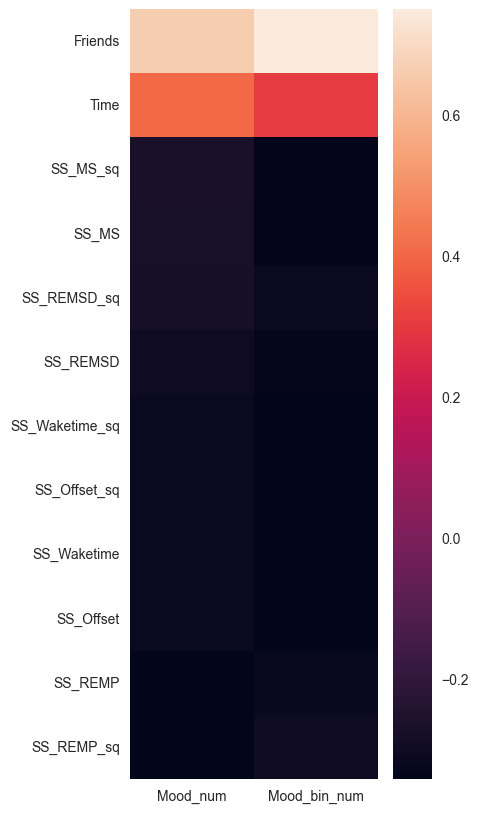

In [7]:
ax, fig = plt.subplots(figsize=(4, 10))
sns.heatmap(df[features].corr()[['Mood_num', 'Mood_bin_num']][2:].sort_values(by='Mood_num', ascending=False));

I don't believe the square features are adding any additional value so they will be dropped

In [8]:
features = list(corr.index[2:-5])
target_reg = ['Mood_num']
target_class = ['Mood_bin_num']

In [9]:
df[features + target_reg].corr()[['Mood_num']]

,Mood_num
Time,0.407999
Friends,0.660549
SS_Waketime,-0.312880
SS_REMSD,-0.300537
SS_MS,-0.270524
SS_REMP,-0.339101
SS_Offset,-0.312880
Mood_num,1.000000


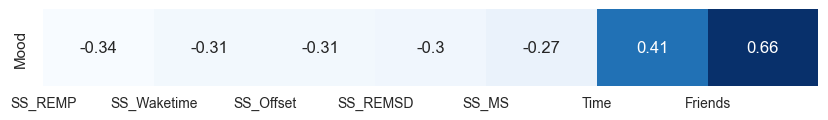

In [10]:
fig, ax = plt.subplots(figsize=(10, 1))
sns.heatmap(df[features + target_reg].corr()[target_reg][:-1].sort_values(by=target_reg).transpose(), 
            cbar=None, cmap='Blues', annot=True)
plt.xticks(rotation=0, 
           labels=[t.get_text() for t in ax.get_xticklabels()], 
           ticks=range(len(features)))
plt.yticks(rotation=0,
           labels=['' for t in ax.get_yticklabels()],
           ticks=range(1))
plt.ylabel('Mood', rotation=90)
plt.savefig('../visuals/models/mood_reg/Heatmap.png', bbox_inches = 'tight');

## Model Selection

In [11]:
df = df[features + target_reg + target_class].dropna(thresh=len(features) - 2)
df_reg = df[features + target_reg]
df_class = df[features + target_class]

In [12]:
df.shape

(42, 9)

### Regression Task - Mood_num

In [13]:
df_reg.head()

,Time,Friends,SS_Waketime,SS_REMSD,SS_MS,SS_REMP,SS_Offset,Mood_num
0,16.200000,0,7.529444,89.0,87.0,19.56,7.529444,2
1,20.750000,0,7.312222,96.0,94.0,20.82,7.312222,1
2,18.350000,1,6.980000,106.0,91.0,23.71,6.980000,4
3,22.733333,0,6.884722,31.0,53.0,7.54,6.884722,4
4,22.150000,0,7.265833,74.0,83.0,19.58,7.265833,2


In [14]:
df_reg.Mood_num.value_counts()

3    16
2     9
4     7
1     6
0     4
Name: Mood_num, dtype: int64

In [15]:
reg = r.setup(df_reg, 
                   target = 'Mood_num', 
                   normalize=True, session_id=101)

,Description,Value
0,session_id,101
1,Target,Mood_num
2,Original Data,"(42, 8)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(29, 6)"


In [16]:
best_reg = r.compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.6056,0.6176,0.7168,-0.2501,0.2785,0.2732,0.0060
lr,Linear Regression,0.6137,0.6476,0.7241,-0.3051,0.2715,0.2761,0.5960
huber,Huber Regressor,0.6194,0.6292,0.7065,-0.3010,0.2677,0.2788,0.0070
ridge,Ridge Regression,0.6249,0.6430,0.7359,-0.2913,0.2928,0.2834,0.0060
omp,Orthogonal Matching Pursuit,0.7294,0.7112,0.7711,-0.1623,0.3180,0.2892,0.0050
ada,AdaBoost Regressor,0.8010,1.0497,0.9302,-0.4063,0.3718,0.3647,0.0270
et,Extra Trees Regressor,0.8435,1.1063,0.9525,-0.6209,0.3788,0.3619,0.0560
rf,Random Forest Regressor,0.8592,1.0550,0.9285,-0.4979,0.3685,0.3747,0.0740
gbr,Gradient Boosting Regressor,0.8660,1.1814,0.9675,-0.7945,0.3812,0.4318,0.0140
knn,K Neighbors Regressor,0.8767,1.2807,1.0115,-0.9866,0.3923,0.3844,0.0080


#### Tuning Bayesian Ridge

In [17]:
tuned_reg = r.tune_model(best_reg)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0507,1.2839,1.1331,-0.9258,0.6137,0.5394
1,0.1883,0.0751,0.2740,0.9625,0.1230,0.1812
2,1.1042,1.5995,1.2647,-6.1976,0.3784,0.3252
3,0.5091,0.2618,0.5117,-0.1781,0.1393,0.1947
4,0.5424,0.3515,0.5929,0.6046,0.1790,0.2990
5,0.5480,0.6189,0.7867,0.6905,0.4924,0.0505
6,0.3943,0.2546,0.5046,0.7136,0.1168,0.1273
7,0.2830,0.1088,0.3298,0.8368,0.0735,0.0850
8,0.4824,0.4240,0.6511,0.5230,0.2553,0.4053


In [18]:
print(tuned_reg)

BayesianRidge(alpha_1=0.001, alpha_2=0.05, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=0.1, lambda_2=0.3,
              lambda_init=None, n_iter=300, normalize=False, tol=0.001,
              verbose=False)


#### Predicting with Best Regression

In [19]:
r.predict_model(tuned_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.1103,1.7659,1.3289,-0.5072,0.4923,0.4297


,Time,Friends,SS_Waketime,SS_REMSD,SS_MS,SS_REMP,Mood_num,Label
0,0.725913,0,-0.350465,0.703714,1.273915,0.402696,1,2.423314
1,-0.514926,0,-0.284582,0.662319,0.809800,0.668416,2,1.562916
2,-0.610009,1,0.100761,-0.952084,-1.325127,0.574066,3,1.669904
3,0.317054,0,1.465815,-1.324639,-1.696419,-1.285972,2,1.213937
4,-0.120330,1,-0.635325,-1.117664,-1.510773,-0.985593,3,2.699354
5,1.291659,0,-1.079915,-1.986958,-2.531826,-2.154375,4,1.144942
6,0.597550,1,-0.324397,-0.289765,-0.304075,-0.419495,4,3.390925
7,0.231479,0,-0.096414,0.289765,0.624154,0.058031,2,2.077098
8,0.150658,0,1.284281,-0.165580,0.252862,-0.142222,0,2.093140
9,-0.472139,0,0.940174,0.331160,0.160040,0.083062,3,1.457464


#### Evaluate Model

In [20]:
path = '../visuals/models/mood_reg'

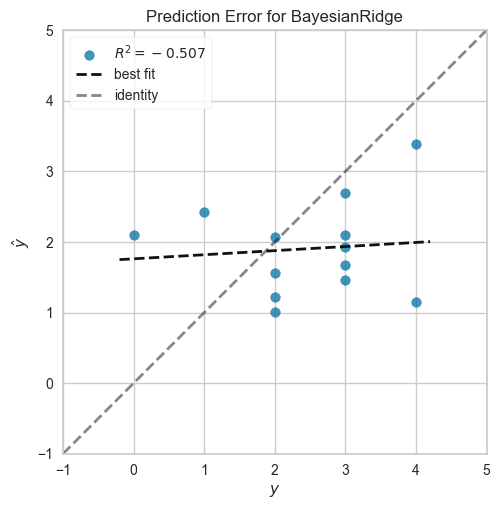

In [21]:
r.plot_model(tuned_reg, plot='error', save=path)
r.plot_model(tuned_reg, plot='error')

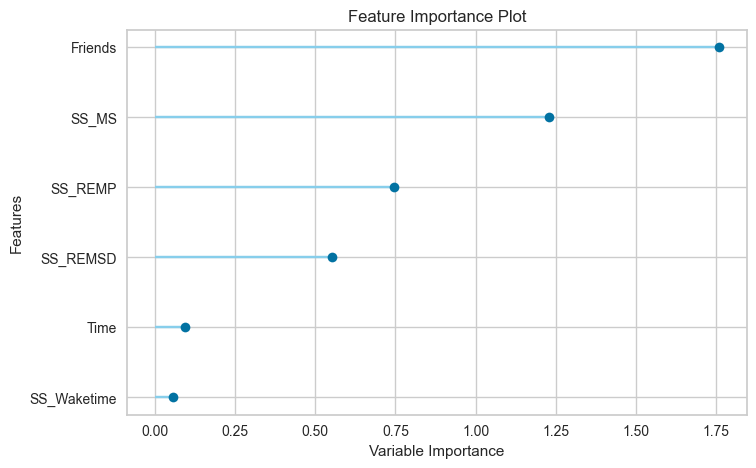

In [22]:
r.plot_model(tuned_reg, plot='feature', save=path)
r.plot_model(tuned_reg, plot='feature')

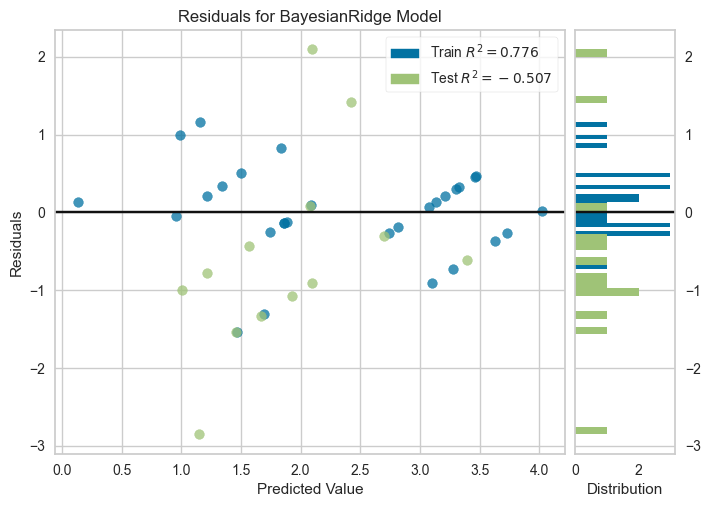

In [23]:
r.plot_model(tuned_reg, plot='residuals', save=path)
r.plot_model(tuned_reg, plot='residuals')

#### Save the Baysian Ridge Regression Model

In [24]:
#r.save_model(tuned_reg, '../models/MoodBayesianRidgeRegressionModel')

### Classification Task - Mood_bin_num

In [25]:
df_class.head()

,Time,Friends,SS_Waketime,SS_REMSD,SS_MS,SS_REMP,SS_Offset,Mood_bin_num
0,16.200000,0,7.529444,89.0,87.0,19.56,7.529444,0
1,20.750000,0,7.312222,96.0,94.0,20.82,7.312222,0
2,18.350000,1,6.980000,106.0,91.0,23.71,6.980000,1
3,22.733333,0,6.884722,31.0,53.0,7.54,6.884722,1
4,22.150000,0,7.265833,74.0,83.0,19.58,7.265833,0


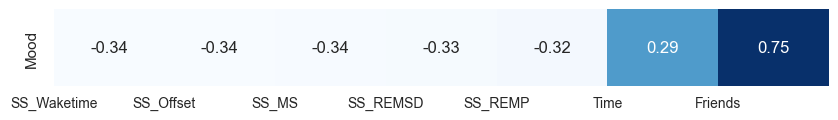

In [26]:
fig, ax = plt.subplots(figsize=(10, 1))
sns.heatmap(df[features + target_class].corr()[target_class][:-1].sort_values(by=target_class).transpose(), 
            cbar=None, cmap='Blues', annot=True)
plt.xticks(rotation=0, 
           labels=[t.get_text() for t in ax.get_xticklabels()], 
           ticks=range(len(features)))
plt.yticks(rotation=0,
           labels=['' for t in ax.get_yticklabels()],
           ticks=range(1))
plt.ylabel('Mood', rotation=90)
plt.savefig('../visuals/models/mood_class/Heatmap.png', bbox_inches = 'tight');

In [27]:
df_class.Mood_bin_num.value_counts()

1    23
0    19
Name: Mood_bin_num, dtype: int64

In [28]:
clas = c.setup(df_class, 
                   target = 'Mood_bin_num', 
                   #polynomial_features=True,
                   normalize=True,session_id=101)

,Description,Value
0,session_id,101
1,Target,Mood_bin_num
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(42, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [29]:
best_class = c.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9167,0.9500,0.8000,0.8000,0.8000,0.8000,0.8000,0.0060
ridge,Ridge Classifier,0.9167,0.0000,0.8000,0.8000,0.8000,0.8000,0.8000,0.0050
lda,Linear Discriminant Analysis,0.9167,0.9500,0.8000,0.8000,0.8000,0.8000,0.8000,0.0050
lr,Logistic Regression,0.8833,0.9500,0.8000,0.7500,0.7667,0.7400,0.7500,0.0120
dt,Decision Tree Classifier,0.8833,0.8500,0.8000,0.7667,0.7800,0.7000,0.7000,0.0060
rf,Random Forest Classifier,0.8833,0.8000,0.8000,0.7667,0.7800,0.7000,0.7000,0.0950
et,Extra Trees Classifier,0.8833,0.9000,0.8000,0.7667,0.7800,0.7000,0.7000,0.0780
gbc,Gradient Boosting Classifier,0.8500,0.8500,0.8000,0.7333,0.7600,0.6000,0.6000,0.0230
knn,K Neighbors Classifier,0.8167,0.8000,0.7500,0.7000,0.7167,0.5900,0.6000,0.0260
ada,Ada Boost Classifier,0.8167,0.9500,0.8000,0.6833,0.7267,0.5400,0.5500,0.0350


#### Tune Linear Discriminant Analysis

In [30]:
best_class = c.create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [31]:
tuned_class = c.tune_model(best_class)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


#### Predict with Linear Discriminant Analysis

In [32]:
c.predict_model(tuned_class)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.6923,0.7143,0.4286,1.0000,0.6000,0.4091,0.5071


,Time,Friends,SS_Waketime,SS_REMSD,SS_MS,SS_REMP,Mood_bin_num,Label,Score
0,0.725913,0,-0.350465,0.703714,1.273915,0.402696,0,0,0.9952
1,-0.514926,0,-0.284582,0.662319,0.809800,0.668416,0,0,0.9959
2,-0.610009,1,0.100761,-0.952084,-1.325127,0.574066,1,1,0.9984
3,0.317054,0,1.465815,-1.324639,-1.696419,-1.285972,0,0,1.0000
4,-0.120330,1,-0.635325,-1.117664,-1.510773,-0.985593,1,1,0.9999
5,1.291659,0,-1.079915,-1.986958,-2.531826,-2.154375,1,0,0.9996
6,0.597550,1,-0.324397,-0.289765,-0.304075,-0.419495,1,1,0.9999
7,0.231479,0,-0.096414,0.289765,0.624154,0.058031,0,0,0.9970
8,0.150658,0,1.284281,-0.165580,0.252862,-0.142222,0,0,0.9996
9,-0.472139,0,0.940174,0.331160,0.160040,0.083062,1,0,0.9994


#### Evaluate Model

In [33]:
path = '../visuals/models/mood_class'

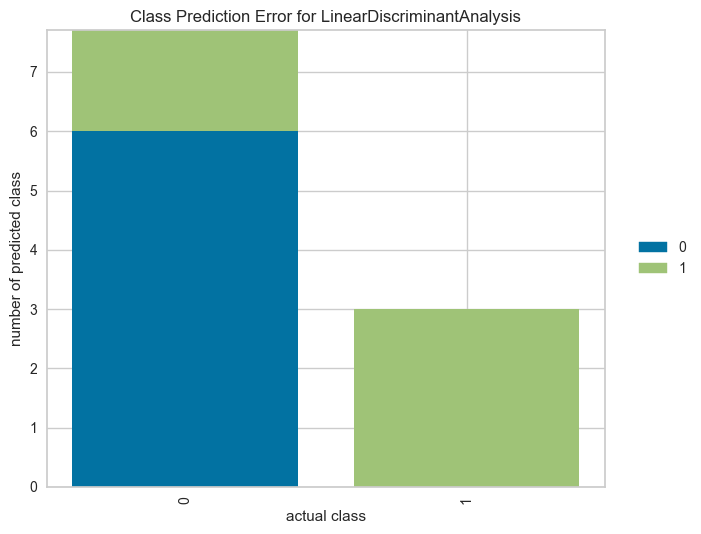

In [34]:
c.plot_model(tuned_class, 'error', save=path)
c.plot_model(tuned_class, 'error')

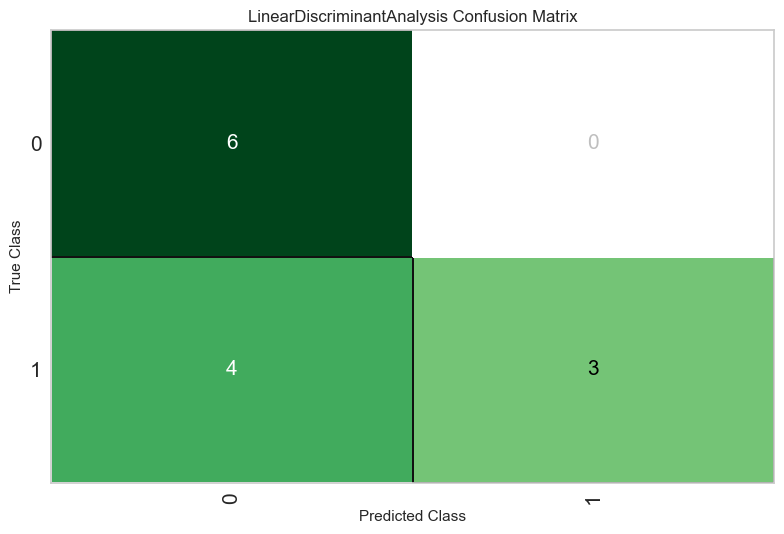

In [35]:
c.plot_model(tuned_class, 'confusion_matrix', save=path)
c.plot_model(tuned_class, 'confusion_matrix')

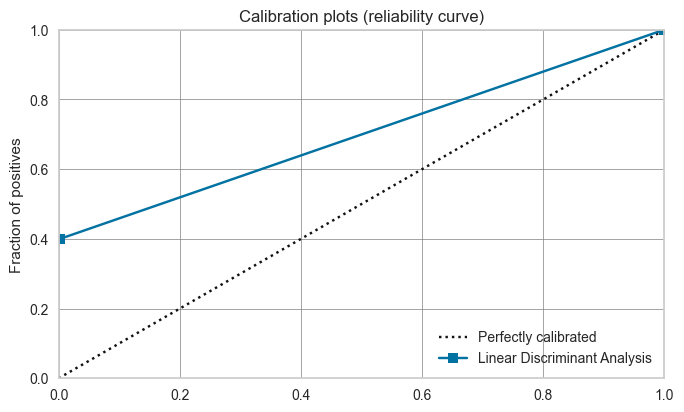

In [36]:
c.plot_model(tuned_class, 'calibration', save=path)
c.plot_model(tuned_class, 'calibration')

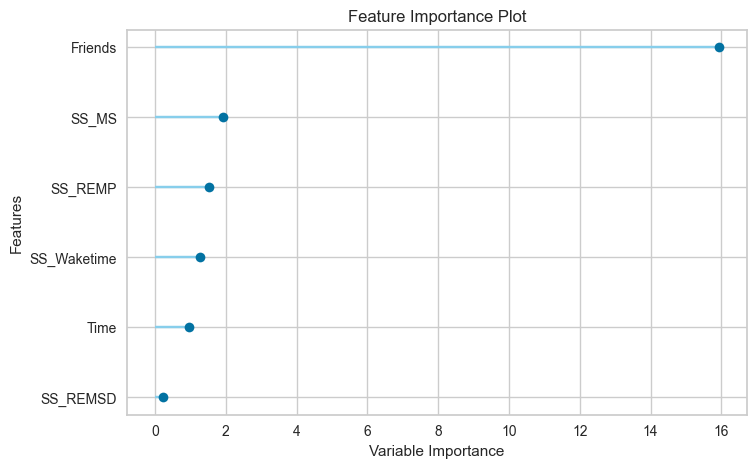

In [37]:
c.plot_model(tuned_class, 'feature', save=path)
c.plot_model(tuned_class, 'feature')

#### Save the Linear Discriminant Analysis Model

In [38]:
#c.save_model(tuned_class, '../models/MoodLDAModel')

In [39]:
clas = c.setup(df_class, 
                   target = 'Mood_bin_num', 
                   #polynomial_features=True,
                   normalize=True,session_id=101)

,Description,Value
0,session_id,101
1,Target,Mood_bin_num
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(42, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [40]:
best_class_recall = c.compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5500,0.5000,1.0000,0.5500,0.6967,0.0000,0.0000,0.0060
dummy,Dummy Classifier,0.5500,0.5000,1.0000,0.5500,0.6967,0.0000,0.0000,0.0040
qda,Quadratic Discriminant Analysis,0.7000,0.6500,0.9000,0.6500,0.7400,0.3200,0.3500,0.0050
lr,Logistic Regression,0.8833,0.9500,0.8000,0.7500,0.7667,0.7400,0.7500,0.0060
nb,Naive Bayes,0.9167,0.9500,0.8000,0.8000,0.8000,0.8000,0.8000,0.0040
dt,Decision Tree Classifier,0.8833,0.8500,0.8000,0.7667,0.7800,0.7000,0.7000,0.0050
ridge,Ridge Classifier,0.9167,0.0000,0.8000,0.8000,0.8000,0.8000,0.8000,0.0040
rf,Random Forest Classifier,0.8833,0.8000,0.8000,0.7667,0.7800,0.7000,0.7000,0.0860
ada,Ada Boost Classifier,0.8167,0.9500,0.8000,0.6833,0.7267,0.5400,0.5500,0.0330
gbc,Gradient Boosting Classifier,0.8500,0.8500,0.8000,0.7333,0.7600,0.6000,0.6000,0.0210


#### Tune Linear Discriminant Analysis

In [41]:
best_class_recall = c.create_model('qda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7500,1.0000,0.5000,0.6667,0.4000,0.5000
1,0.6667,0.5000,1.0000,0.5000,0.6667,0.4000,0.5000
2,0.6667,0.7500,1.0000,0.5000,0.6667,0.4000,0.5000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.6667,0.5000,1.0000,0.6667,0.8000,0.0000,0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.6667,0.5000,1.0000,0.6667,0.8000,0.0000,0.0000
7,0.6667,0.5000,1.0000,0.6667,0.8000,0.0000,0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [42]:
tuned_class_recall = c.tune_model(best_class_recall)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


#### Predict with Linear Discriminant Analysis

In [43]:
c.predict_model(tuned_class_recall)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.5385,0.5476,0.5714,0.5714,0.5714,0.0714,0.0714


,Time,Friends,SS_Waketime,SS_REMSD,SS_MS,SS_REMP,Mood_bin_num,Label,Score
0,0.725913,0,-0.350465,0.703714,1.273915,0.402696,0,1,0.5013
1,-0.514926,0,-0.284582,0.662319,0.809800,0.668416,0,0,0.5789
2,-0.610009,1,0.100761,-0.952084,-1.325127,0.574066,1,1,0.9874
3,0.317054,0,1.465815,-1.324639,-1.696419,-1.285972,0,1,0.9999
4,-0.120330,1,-0.635325,-1.117664,-1.510773,-0.985593,1,1,0.9998
5,1.291659,0,-1.079915,-1.986958,-2.531826,-2.154375,1,1,0.9973
6,0.597550,1,-0.324397,-0.289765,-0.304075,-0.419495,1,1,0.9985
7,0.231479,0,-0.096414,0.289765,0.624154,0.058031,0,0,0.8607
8,0.150658,0,1.284281,-0.165580,0.252862,-0.142222,0,0,0.9825
9,-0.472139,0,0.940174,0.331160,0.160040,0.083062,1,0,0.9875


#### Evaluate Model

In [44]:
path = '../visuals/models/mood_class_recall'

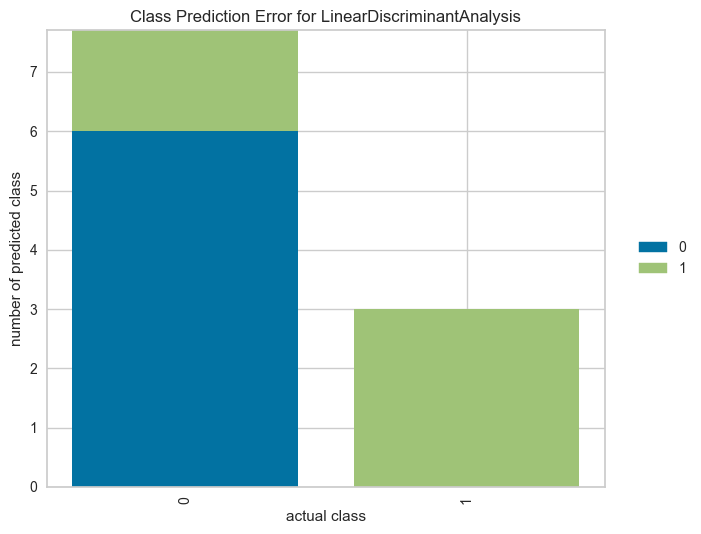

In [45]:
c.plot_model(tuned_class, 'error', save=path)
c.plot_model(tuned_class, 'error')

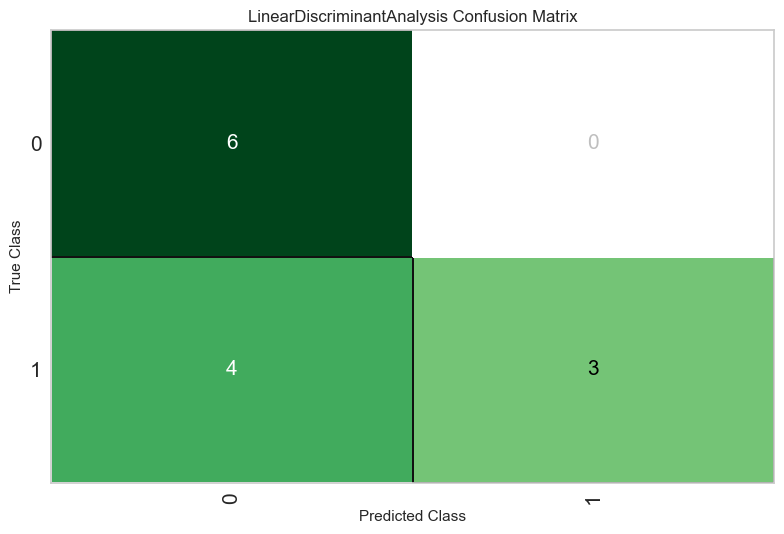

In [46]:
c.plot_model(tuned_class, 'confusion_matrix', save=path)
c.plot_model(tuned_class, 'confusion_matrix')

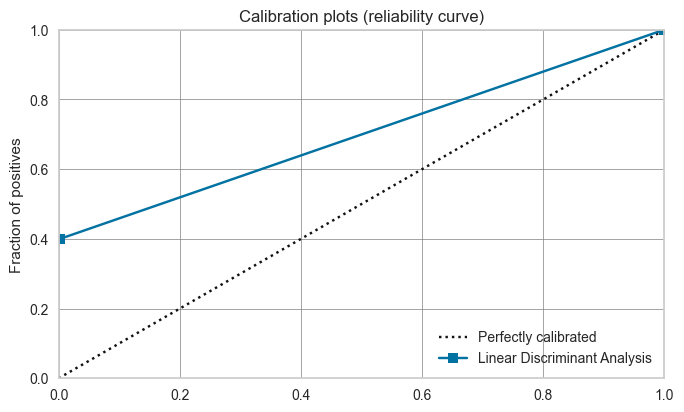

In [47]:
c.plot_model(tuned_class, 'calibration', save=path)
c.plot_model(tuned_class, 'calibration')

In [48]:
#c.plot_model(tuned_class, 'feature', save=path)
#c.plot_model(tuned_class, 'feature')

#### Save the Linear Discriminant Analysis Model

In [49]:
#c.save_model(tuned_class, '../models/MoodQDAModel')